# Import packages, set matplotlib params

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from iminuit import Minuit
from iminuit.cost import LeastSquares

%matplotlib inline

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 4.0
plt.rcParams['lines.linewidth'] = 2.0

# Read `.xlsx` files into pandas Dataframe

In [2]:
df0 = pd.read_excel('TRD_Dalyr.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])
df1 = pd.read_excel('TRD_Dalyr1.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])
df2 = pd.read_excel('TRD_Dalyr2.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])
df3 = pd.read_excel('TRD_Dalyr3.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])

df = pd.concat([df0, df1, df2, df3])

/opt/miniconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Calculate the risk expectation `V(n)` of n-combined stocks

In [3]:
cov = df.set_index(['Trddt', 'Stkcd']).unstack().dropna(axis=1, how='any').cov().values
N = len(cov)
indices = np.arange(N)
n = np.arange(1, 101)
sampleN = 10000

def averV(ni):
    index = np.random.choice(N, size=ni)
    return cov[index].T[index].sum() / ni / ni

averVvec = np.vectorize(averV)

aver = np.empty(len(n))
vmin = np.empty(len(n))
vmax = np.empty(len(n))
vstd = np.empty(len(n))

for i, ni in enumerate(n):
    d = averVvec(np.full(sampleN, ni))
    aver[i] = np.mean(d)
    vmin[i] = np.min(d)
    vmax[i] = np.max(d)
    vstd[i] = np.std(d, ddof=-1)

# Draw the covariance matrix of first 10 stocks's risk

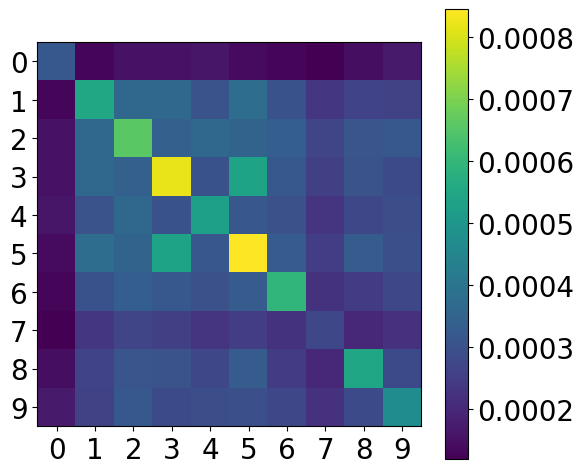

In [4]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
cp = ax.imshow(cov[:10, :10])
fig.colorbar(cp, ax=ax)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10).astype(str))
ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10).astype(str))
# fig.savefig('')
plt.show()

# Draw the relation between risk expectation `V(n)` and `n`

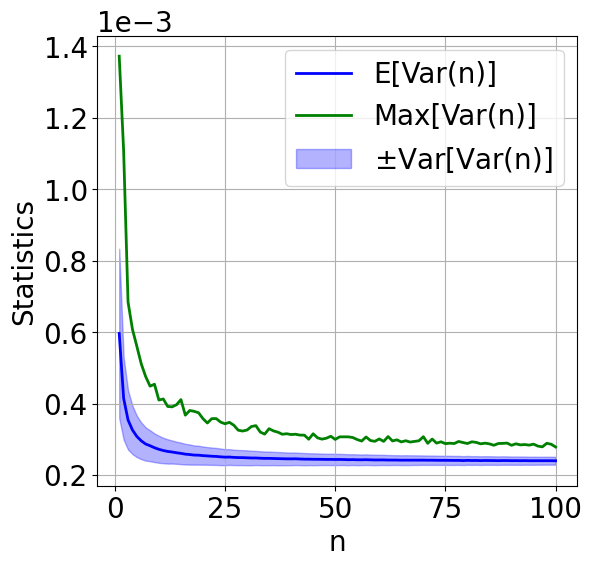

In [5]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
ax.plot(n, aver, color='b', label='E[Var(n)]')
ax.fill_between(n, aver - vstd, aver + vstd, color='b', alpha=0.3, label=r'$\pm$Var[Var(n)]')
ax.plot(n, vmax, color='g', label='Max[Var(n)]')
# ax.plot(n, vmin, color='y', label='Min[Var(n)]')
ax.set_xlabel('n')
ax.set_ylabel('Statistics')
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.legend()
# ax.set_yscale('log')
fig.savefig('data.png')
plt.show()

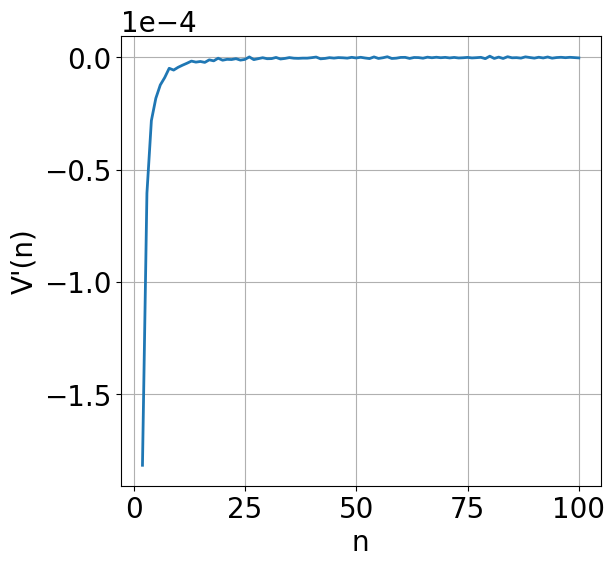

In [6]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
ax.plot(n[1:], np.diff(aver), label="V'(n)")
ax.set_xlabel('n')
ax.set_ylabel("V'(n)")
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
# ax.legend()
# ax.set_yscale('log')
# fig.savefig('')
plt.show()

In [7]:
var = np.trace(cov)
covv = cov.sum() - var

def V(n, a):
    return (var / N - covv / N  / (N - 1)) / (n ** a) + covv / N  / (N - 1)

least_squares = LeastSquares(n, aver, aver / np.sqrt(sampleN), V)

m = Minuit(least_squares, a=1, name=('a'))
m.limits['a'] = (0, 2)
m.errordef = 0.5
m.migrad()
# m.hesse()
m.minos()

fit_info = []
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f'{p} = ${v:.3f} \\pm {e:.3f}$')

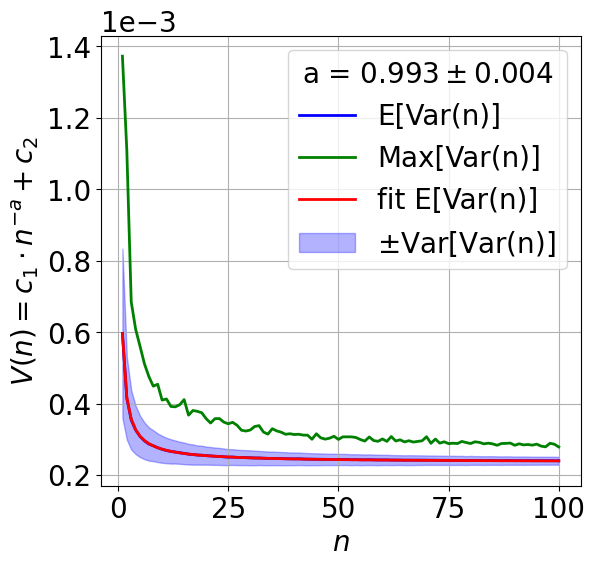

In [8]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
ax.plot(n, aver, color='b', label='E[Var(n)]')
ax.fill_between(n, aver - vstd, aver + vstd, color='b', alpha=0.3, label=r'$\pm$Var[Var(n)]')
ax.plot(n, vmax, color='g', label='Max[Var(n)]')
ax.plot(n, V(n, *m.values), color='r', label='fit E[Var(n)]')
ax.set_xlabel('$n$')
ax.set_ylabel('$V(n)=c_1 \cdot n^{-a} + c_2$')
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.legend(title='\n'.join(fit_info))
# ax.set_yscale('log')
fig.savefig('fit.png')
plt.show()